In [1]:
!git clone 'https://github.com/AntonioTepsich/Convolutional-KANs.git'
!cd Convolutional-KANs


Cloning into 'Convolutional-KANs'...
remote: Enumerating objects: 2379, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2379 (delta 266), reused 311 (delta 196), pack-reused 1970 (from 1)
Receiving objects: 100% (2379/2379), 45.65 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (1286/1286), done.


In [5]:
from Convolutional_KANs.kan_convolutional.KANConv import KAN_Convolutional_Layer

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = datasets.VOCSegmentation(root=root, year='2012', image_set='train', download=True).images
        self.masks = datasets.VOCSegmentation(root=root, year='2012', image_set='train', download=True).targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Определение преобразований
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
import gc

# В конце каждой эпохи
gc.collect()
torch.cuda.empty_cache()

# Создание экземпляра вашего пользовательского датасета
dataset = CustomDataset(root='data/VOC', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

100%|██████████| 2.00G/2.00G [01:25<00:00, 23.4MB/s]


Extracting data/VOC/VOCtrainval_11-May-2012.tar to data/VOC
Using downloaded and verified file: data/VOC/VOCtrainval_11-May-2012.tar
Extracting data/VOC/VOCtrainval_11-May-2012.tar to data/VOC


In [7]:
import torch
import torch.nn.functional as F
import math


import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=True):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [8]:
#Credits to: https://github.com/detkov/Convolution-From-Scratch/
import torch
import numpy as np
from typing import List, Tuple, Union


def calc_out_dims(matrix, kernel_side, stride, dilation, padding):
    batch_size,n_channels,n, m = matrix.shape

    h_out =  np.floor((n + 2 * padding[0] - kernel_side - (kernel_side - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - kernel_side - (kernel_side - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    b = [kernel_side // 2, kernel_side// 2]
    return h_out,w_out,batch_size,n_channels

def multiple_convs_kan_conv2d(matrix, #but as torch tensors. Kernel side asume q el kernel es cuadrado
             kernels,
             kernel_side,
             out_channels,
             stride= (1, 1),
             dilation= (1, 1),
             padding= (0, 0),
             device= "cuda"
             ) -> torch.Tensor:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.

    Args:
        matrix (batch_size, colors, n, m]): 2D matrix to be convolved.
        kernel  (function]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).

    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    h_out, w_out,batch_size,n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    n_convs = len(kernels)
    matrix_out = torch.zeros((batch_size,out_channels,h_out,w_out)).to(device)#estamos asumiendo que no existe la dimension de rgb
    unfold = torch.nn.Unfold((kernel_side,kernel_side), dilation=dilation, padding=padding, stride=stride)
    conv_groups = unfold(matrix[:,:,:,:]).view(batch_size, n_channels,  kernel_side*kernel_side, h_out*w_out).transpose(2, 3)#reshape((batch_size,n_channels,h_out,w_out))
    #for channel in range(n_channels):
    kern_per_out = len(kernels)//out_channels
    #print(len(kernels),out_channels)
    for c_out in range(out_channels):
        out_channel_accum = torch.zeros((batch_size, h_out, w_out), device=device)

        # Aggregate outputs from each kernel assigned to this output channel
        for k_idx in range(kern_per_out):
            kernel = kernels[c_out * kern_per_out + k_idx]
            conv_result = kernel.conv.forward(conv_groups[:, k_idx, :, :].flatten(0, 1))  # Apply kernel with non-linear function
            out_channel_accum += conv_result.view(batch_size, h_out, w_out)

        matrix_out[:, c_out, :, :] = out_channel_accum  # Store results in output tensor

    return matrix_out
def add_padding(matrix: np.ndarray,
                padding: Tuple[int, int]) -> np.ndarray:
    """Adds padding to the matrix.

    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix

    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
    """
    n, m = matrix.shape
    r, c = padding

    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix

    return padded_matrix

In [9]:
import torch
import math
import sys
sys.path.append('./kan_convolutional')
from Convolutional_KANs.kan_convolutional.KANLinear import KANLinear
import Convolutional_KANs.kan_convolutional.convolution


#Script que contiene la implementación del kernel con funciones de activación.
class KAN_Convolutional_Layer(torch.nn.Module):
    def __init__(
            self,
            in_channels: int = 1,
            out_channels: int = 1,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            spline_order:int = 3,
            scale_noise:float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device: str = "cpu"
        ):
        """
        Kan Convolutional Layer with multiple convolutions

        Args:
            n_convs (int): Number of convolutions to apply
            kernel_size (tuple): Size of the kernel
            stride (tuple): Stride of the convolution
            padding (tuple): Padding of the convolution
            dilation (tuple): Dilation of the convolution
            grid_size (int): Size of the grid
            spline_order (int): Order of the spline
            scale_noise (float): Scale of the noise
            scale_base (float): Scale of the base
            scale_spline (float): Scale of the spline
            base_activation (torch.nn.Module): Activation function
            grid_eps (float): Epsilon of the grid
            grid_range (tuple): Range of the grid
            device (str): Device to use
        """


        super(KAN_Convolutional_Layer, self).__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels

        self.grid_size = grid_size
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        # self.device = device
        self.dilation = dilation
        self.padding = padding
        self.convs = torch.nn.ModuleList()
        self.stride = stride


        # Create n_convs KAN_Convolution objects
        for _ in range(in_channels*out_channels):
            self.convs.append(
                KAN_Convolution(
                    kernel_size= kernel_size,
                    stride = stride,
                    padding=padding,
                    dilation = dilation,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                    # device = device ## changed device to be allocated as per the input device for pytorch DDP
                )
            )

    def forward(self, x: torch.Tensor):
        # If there are multiple convolutions, apply them all
        self.device = x.device
        #if self.n_convs>1:
        return Convolutional_KANs.kan_convolutional.convolution.multiple_convs_kan_conv2d(x, self.convs,self.kernel_size[0],self.out_channels,self.stride,self.dilation,self.padding,self.device)

        # If there is only one convolution, apply it
        #return self.convs[0].forward(x)


class KAN_Convolution(torch.nn.Module):
    def __init__(
            self,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            spline_order: int = 3,
            scale_noise: float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device = "cpu"
        ):
        """
        Args
        """
        super(KAN_Convolution, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        # self.device = device
        self.conv = KANLinear(
            in_features = math.prod(kernel_size),
            out_features = 1,
            grid_size=grid_size,
            spline_order=spline_order,
            scale_noise=scale_noise,
            scale_base=scale_base,
            scale_spline=scale_spline,
            base_activation=base_activation,
            grid_eps=grid_eps,
            grid_range=grid_range
        )

    def forward(self, x: torch.Tensor):
        self.device = x.device
        return convolution.kan_conv2d(x, self.conv,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum( layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)


In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
class KANC_MLP(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=3,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 6,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(1, 1)
        )

        self.flat = nn.Flatten()
        self.conv3 = KAN_Convolutional_Layer(in_channels=6,
            out_channels= 7,
            kernel_size = (3,3),
            grid_size = grid_size
        )
        self.conv4 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 8,
            kernel_size = (3,3),
            grid_size = grid_size
        )
        self.upsample4 = nn.ConvTranspose2d(8, 8, 3, stride=1, padding=1)
        self.conv5 = KAN_Convolutional_Layer(in_channels=8,
            out_channels= 8,
            kernel_size = (3,3),
            grid_size = grid_size
        )
        self.conv6 = KAN_Convolutional_Layer(in_channels=8,
            out_channels= 9,
            kernel_size = (1,1),
            grid_size = grid_size
        )
        self.conv7 =KAN_Convolutional_Layer(in_channels=6,
            out_channels= 5,
            kernel_size = (3,3),
            grid_size = grid_size
        )
        self.conv8 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 4,
            kernel_size = (1,1),
            grid_size = grid_size
        )
        self.linear1 = nn.Linear(10443,21)
        self.name = f"KANC MLP (Small) (gs = {grid_size})"


    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x6 = self.conv4(x2)
        x7 = self.pool1(x6)
        x9 = self.conv5(x7)
        x10 = self.conv6(x9)
        print('x7 - pool',x7.shape)
        out = F.interpolate(x10, size=128)
        print('out',out.shape)
        print(x.shape)

        return out
net = KANC_MLP()


# Инициализация модели
model = KANC_MLP()  # 21 классов для Pascal VOC
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





In [12]:
# Обучение модели
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Обучение модели
num_epochs = 1
for epoch in range(num_epochs):
    for images, masks in dataloader:

        images = images.to(device)
        masks = masks.to(device)

        # Проверка размеров
        #print("Images shape:", images.shape)
        print("Masks shape:", masks.shape)

        optimizer.zero_grad()
        #outputs.squeeze(1)
        outputs = model(images)
        #outputs.squeeze(1)
        masks.squeeze(1)
        masks = torch.argmax(masks, dim=1)
        print(masks.shape)
        # Проверка размеров выходов
        print("Outputs shape:", outputs.shape)
        #print(outputs.squeeze(1).shape)
        loss = criterion(outputs, masks)  # Убедитесь, что размеры совпадают
        loss.backward()
        optimizer.step()


        # Освобождение памяти
        gc.collect()
        torch.cuda.empty_cache()
        n =0
        for i in enumerate(dataloader,0):
            if i[0] % 1000 == 999:    # print every 2000 mini-batches
              print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
              break
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Masks shape: torch.Size([1, 1, 128, 128])
x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128])
Outputs shape: torch.Size([1, 9, 128, 128])
Epoch [1/1], Loss: 2.2185
Masks shape: torch.Size([1, 1, 128, 128])
x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128])
Outputs shape: torch.Size([1, 9, 128, 128])
Epoch [1/1], Loss: 2.1764
Masks shape: torch.Size([1, 1, 128, 128])
x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128])
Outputs shape: torch.Size([1, 9, 128, 128])
Epoch [1/1], Loss: 2.1492
Masks shape: torch.Size([1, 1, 128, 128])
x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128])
Outputs shape: torch.Size([1, 9, 128, 128])
Epoch [1/1], Loss: 2.0998
Masks shape: torch.Size([1, 1, 128, 128])


KeyboardInterrupt: 

x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])


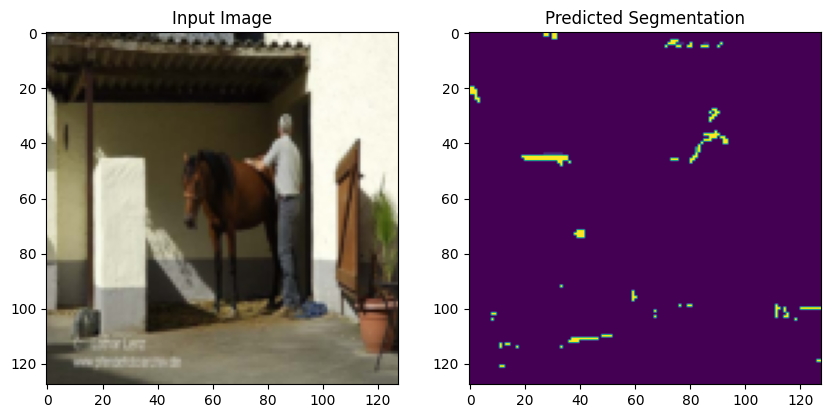

x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])


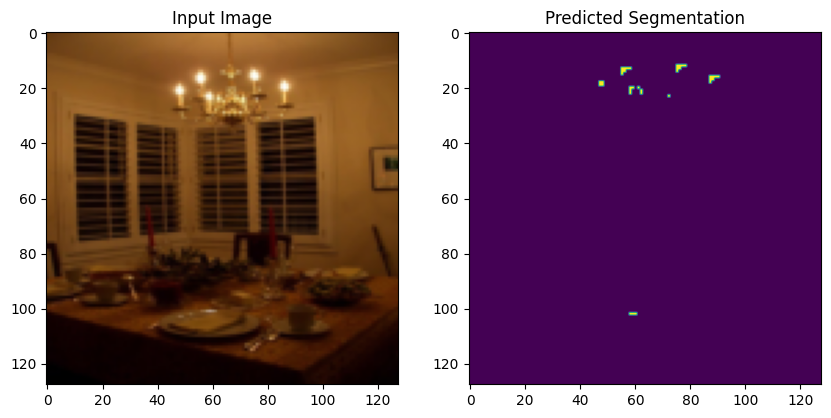

x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])


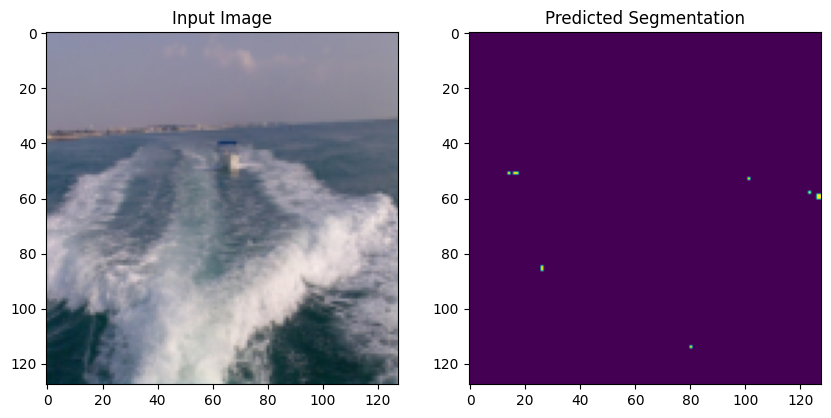

x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])


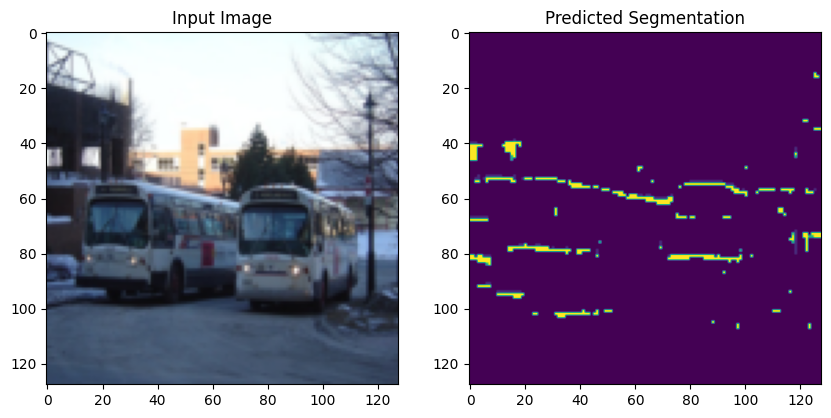

x7 - pool torch.Size([1, 8, 124, 124])
out torch.Size([1, 9, 128, 128])
torch.Size([1, 3, 128, 128])


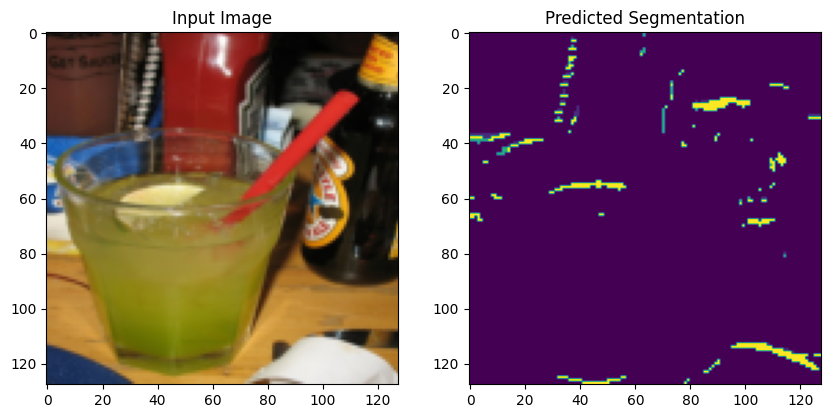

KeyboardInterrupt: 

In [ ]:
model.eval()
m = 40
a = [1,1,1,1,1,1,1,1,1]
for n in a:
  with torch.no_grad():
      #masks =
      sample_image, _ = dataset[m]
      sample_image = sample_image.unsqueeze(0).to(device)  # Добавляем размерность батча
      output = model(sample_image)
      output_predictions = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
      m += 1

  # Визуализация результата
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title('Input Image')
  plt.imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
  plt.subplot(1, 2, 2)
  plt.title('Predicted Segmentation')
  plt.imshow(output_predictions)
  plt.show()